# 🧠 AI Agent: Text Classification using DistilBERT

## 🗂️ Overview
This module aims to build an AI agent capable of classifying text data using a pre-trained DistilBERT model (`distilbert/distilbert-base-uncased-finetuned-sst-2-english`). The pipeline will include data loading, preprocessing, model inference, and result visualization.

---

In [14]:
!pip show transformers

Name: transformers
Version: 4.52.4
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [15]:
import transformers

In [16]:
transformers.__version__

'4.52.4'

## 0. Load Libraries


In [17]:
# 📁 Data Handling and Preprocessing
import pandas as pd
import numpy as np
import re
import string

# 🔍 Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🤗 Hugging Face Transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline

# 🧠 PyTorch for Model Inference
import torch
from torch.utils.data import Dataset, DataLoader

# 🧪 Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 🌐 Optional: Interface
# CLI / App-based interface (for optional user interaction)
# import gradio as gr      # for building simple web UIs
# import streamlit as st   # for dashboard-like interface
# import argparse          # for CLI if needed
# 📂 Google Drive Integration (if using Colab)


# 🐍 System and Utilities
import os
import random
import warnings
warnings.filterwarnings("ignore")


In [18]:
from google.colab import drive
drive.mount('content')

Drive already mounted at content; to attempt to forcibly remount, call drive.mount("content", force_remount=True).


In [19]:
import os
from google.colab import userdata

# Access the Hugging Face token from Colab secrets
hf_token = userdata.get('HF_TOKEN')

# Set the token as an environment variable (optional, but good practice for some libraries)
os.environ['HF_TOKEN'] = hf_token

print("Hugging Face token accessed and set as environment variable.")

Hugging Face token accessed and set as environment variable.


## 📁 1. Data Preparation

### 1.1 Load Dataset from Google Drive


In [20]:
df = pd.read_csv("/content/content/MyDrive/NLP_with_Transformers/BBC_News_Text_Classification/Data/bbc_data.csv")

In [21]:
df.sample(10)

,data,labels
529,Dollar gains on Greenspan speech The dollar h...,business
1418,Election deal faltered over Heath role The To...,politics
687,Russia WTO talks make progress Talks on Russi...,business
448,Oil prices reach three-month low Oil prices h...,business
997,Newcastle 2-1 Bolton Kieron Dyer smashed home...,sport
1678,Blair says mayor should apologise Tony Blair ...,politics
1202,Healey targets England comeback Leicester win...,sport
1854,Rivals of the xc2xa3400 Apple... The Mac mini...,tech
630,Beer giant swallows Russian firm Brewing gian...,business
1055,Wasps 31-37 Leicester Leicester withstood a s...,sport


In [22]:
df['labels'].unique()

array(['entertainment', 'business', 'sport', 'politics', 'tech'],
      dtype=object)

In [23]:
df.tail(5)

,data,labels
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech
2224,Hacker threat to Apples iTunes Users of Apple...,tech


In [24]:
df.head(5)

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


In [25]:
df.sample(15)

,data,labels
1129,Jones doping probe begins An investigation in...,sport
1765,Brown in appeal for Labour unity Gordon Brown...,politics
1226,Hereford 1-1 Doncaster Hereford win 3-1 on pe...,sport
733,Dollar hits new low versus euro The US dollar...,business
1389,Parker misses England clash Tom Shanklin will...,sport
1253,Collins appeals against drugs ban Sprinter Mi...,sport
1516,Crisis ahead in social sciences A national bo...,politics
1232,Rush future at Chester uncertain Ian Rushs fu...,sport
872,Putin backs state grab for Yukos Russias pres...,business
1736,Blair pledges unity to Labour MPs Tony Blair ...,politics


### 1.2 Inspect and Understand the Data
- Check for null values, class balance, and structure
- Preview sample texts and labels

In [26]:
# Check for null values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 data      0
labels    0
dtype: int64


In [27]:
# Check data types and structure
print("\nData types:\n", df.dtypes)
print("\nDataFrame shape:", df.shape)


Data types:
 data      object
labels    object
dtype: object

DataFrame shape: (2225, 2)


In [28]:
# Check class balance
print("\nClass distribution:\n", df['labels'].value_counts())

# Preview sample texts and labels (already done in previous cells)


Class distribution:
 labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [29]:
df.isna().sum()

,0
data,0
labels,0


### 1.3 Clean and Preprocess Text
- Remove noise (HTML, emojis, special characters)
- Normalize case
- Optional: Remove stopwords, perform lemmatization

In [30]:
df.head(2)

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment


In [31]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Initialize Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove emojis (basic regex, might not catch all)
    text = re.sub(r'[^\w\s#@/:%.\-]+', '', text, flags=re.UNICODE)
    # Remove special characters and punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    # Apply cleaning
    text = clean_text(text)
    # Tokenize (split into words)
    tokens = text.split()
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(processed_tokens)

# Apply the preprocessing function to the 'text' column
df['cleaned_text'] = df['data'].apply(preprocess_text)

# Display the first few rows with the new cleaned_text column
print(df[['data', 'cleaned_text']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                                data  \
0  Musicians to tackle US red tape  Musicians gro...   
1  U2s desire to be number one  U2, who have won ...   
2  Rocker Doherty in on-stage fight  Rock singer ...   
3  Snicket tops US box office chart  The film ada...   
4  Oceans Twelve raids box office  Oceans Twelve,...   

                                        cleaned_text  
0  musician tackle u red tape musician group tack...  
1  u2s desire number one u2 three prestigious gra...  
2  rocker doherty onstage fight rock singer pete ...  
3  snicket top u box office chart film adaptation...  
4  ocean twelve raid box office ocean twelve crim...  


In [32]:
df.sample(10)

,data,labels,cleaned_text
818,Chinese dam firm defies Beijing The China Thr...,business,chinese dam firm defies beijing china three go...
1993,Europe backs digital TV lifestyle How people ...,tech,europe back digital tv lifestyle people receiv...
809,Bank set to leave rates on hold UK interest r...,business,bank set leave rate hold uk interest rate set ...
386,UK economy facing major risks The UK manufact...,business,uk economy facing major risk uk manufacturing ...
312,Christmas song formula unveiled A formula for...,entertainment,christmas song formula unveiled formula ultima...
895,Iraqi voters turn to economic issues Beyond t...,business,iraqi voter turn economic issue beyond despera...
192,Film row over Pirates cannibals Plans to port...,entertainment,film row pirate cannibal plan portray dominica...
1880,Mobiles get set for visual radio The growth i...,tech,mobile get set visual radio growth mobile phon...
682,Indias rupee hits five-year high Indias rupee...,business,india rupee hit fiveyear high india rupee hit ...
1760,England childrens tsar appointed The first ch...,politics,england childrens tsar appointed first childre...


In [33]:
# Further preprocessing steps
# 1. Handle potential empty strings after preprocessing
df['cleaned_text'] = df['cleaned_text'].replace('', np.nan)
df.dropna(subset=['cleaned_text'], inplace=True)


Distribution of text lengths:
count    2225.000000
mean      222.863371
std       127.676518
min        49.000000
25%       145.000000
50%       197.000000
75%       273.000000
max      2237.000000
Name: text_length, dtype: float64


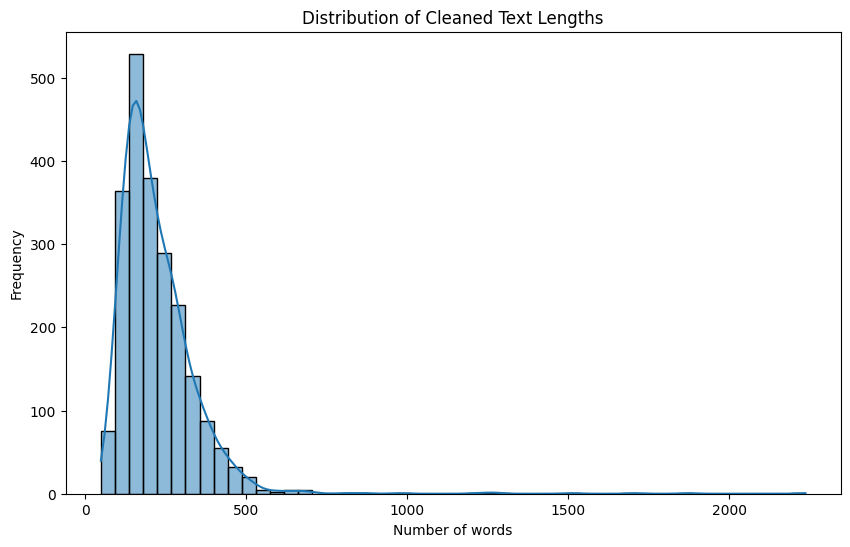

In [34]:
# 2. Check for distribution of text lengths
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
print("\nDistribution of text lengths:")
print(df['text_length'].describe())

# Optional: Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Cleaned Text Lengths')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()



In [35]:
# Optional: Remove very short
# Example: Remove texts shorter than 5 words (arbitrary threshold)
# df = df[df['text_length'] >= ].reset_index(drop=True)
# print(f"\nShape after removing short texts: {df.shape}")

In [36]:

# 3. Re-check class distribution after dropping rows
print("\nClass distribution after preprocessing:")
print(df['labels'].value_counts())




Class distribution after preprocessing:
labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [37]:
df.sample(5)

,data,labels,cleaned_text,text_length
458,Bombardier chief to leave company Shares in t...,business,bombardier chief leave company share train pla...,162
758,Parmalat bank barred from suing Bank of Ameri...,business,parmalat bank barred suing bank america banned...,93
1196,Celtic make late bid for Bellamy Newcastle st...,sport,celtic make late bid bellamy newcastle striker...,116
2143,Broadband in the UK gathers pace One person i...,tech,broadband uk gather pace one person uk joining...,166
808,UK young top Euro earnings league British chi...,business,uk young top euro earnings league british chil...,125


In [38]:
from sklearn.preprocessing import LabelEncoder

# Encode labels to integer classes
le = LabelEncoder()
df['label'] = le.fit_transform(df['labels'])  # Save original classes
num_labels = df['label'].nunique()

# Train-test split
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['data'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)


In [39]:
df

,data,labels,cleaned_text,text_length,label
0,Musicians to tackle US red tape Musicians gro...,entertainment,musician tackle u red tape musician group tack...,210,1
1,"U2s desire to be number one U2, who have won ...",entertainment,u2s desire number one u2 three prestigious gra...,454,1
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment,rocker doherty onstage fight rock singer pete ...,206,1
3,Snicket tops US box office chart The film ada...,entertainment,snicket top u box office chart film adaptation...,118,1
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment,ocean twelve raid box office ocean twelve crim...,177,1
...,...,...,...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech,warning window word file writing microsoft wor...,273,4
2221,Fast lifts rise into record books Two high-sp...,tech,fast lift rise record book two highspeed lift ...,235,4
2222,Nintendo adds media playing to DS Nintendo is...,tech,nintendo add medium playing d nintendo releasi...,162,4
2223,Fast moving phone viruses appear Security fir...,tech,fast moving phone virus appear security firm w...,191,4


In [40]:
# !pip install --upgrade transformers==4.40.1
# After restarting, confirm the correct version is active
import transformers
print(transformers.__version__)  # Should be 4.40.0 or newer
print("Transformers version OK ✅")


4.52.4
Transformers version OK ✅


## 🤗 2. Model Setup: Hugging Face Transformers

### 2.1 Load Pre-trained DistilBERT
- Use `distilbert/distilbert-base-uncased-finetuned-sst-2-english` for binary sentiment classification

### 2.2 Tokenize the Input Data
- Utilize `DistilBertTokenizer`
- Pad and truncate sequences to a consistent length
- Convert tokens to tensor format

---

In [41]:
# 🧩 Step 1: Imports
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

# 🧩 Step 2: Tokenizer Load
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# 🧩 Step 3: Train/Val split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

# 🧩 Step 4: Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# 🧩 Step 5: Dataset Class
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [42]:
## Step 7 : Model Initialization
num_labels = df['label'].nunique()
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased",
    num_labels=num_labels
)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# !pip uninstall -y transformers

In [44]:
# !pip install transformers==4.40.0

In [46]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
)


In [54]:
# ✅ STEP 9: Metrics Function
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [55]:
# ✅ STEP 10: Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [56]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.055000,0.181440,0.968539,0.968739
2,0.038100,0.105217,0.977528,0.977577
3,0.049800,0.107490,0.982022,0.982082
4,0.000700,0.110326,0.982022,0.982082


TrainOutput(global_step=448, training_loss=0.033139217921416275, metrics={'train_runtime': 420.9748, 'train_samples_per_second': 16.913, 'train_steps_per_second': 1.064, 'total_flos': 943218338611200.0, 'train_loss': 0.033139217921416275, 'epoch': 4.0})

In [58]:
# ✅ STEP 11: Save Final Model
model.save_pretrained("bbc_distilbert_model")
tokenizer.save_pretrained("bbc_distilbert_model")

('bbc_distilbert_model/tokenizer_config.json',
 'bbc_distilbert_model/special_tokens_map.json',
 'bbc_distilbert_model/vocab.txt',
 'bbc_distilbert_model/added_tokens.json',
 'bbc_distilbert_model/tokenizer.json')

In [71]:
# ✅ STEP 12: Inference Function
def classify_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device) # Ensure tensor is on the same device as model
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits).item()
    return pred

Evaluation results: {'eval_loss': 0.10521747916936874, 'eval_accuracy': 0.9775280898876404, 'eval_f1': 0.9775769567637238, 'eval_runtime': 9.185, 'eval_samples_per_second': 48.448, 'eval_steps_per_second': 3.048, 'epoch': 4.0}

Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.97      0.96       103
entertainment       0.99      0.99      0.99        84
     politics       0.97      0.96      0.97        80
        sport       1.00      0.98      0.99        98
         tech       0.98      0.99      0.98        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



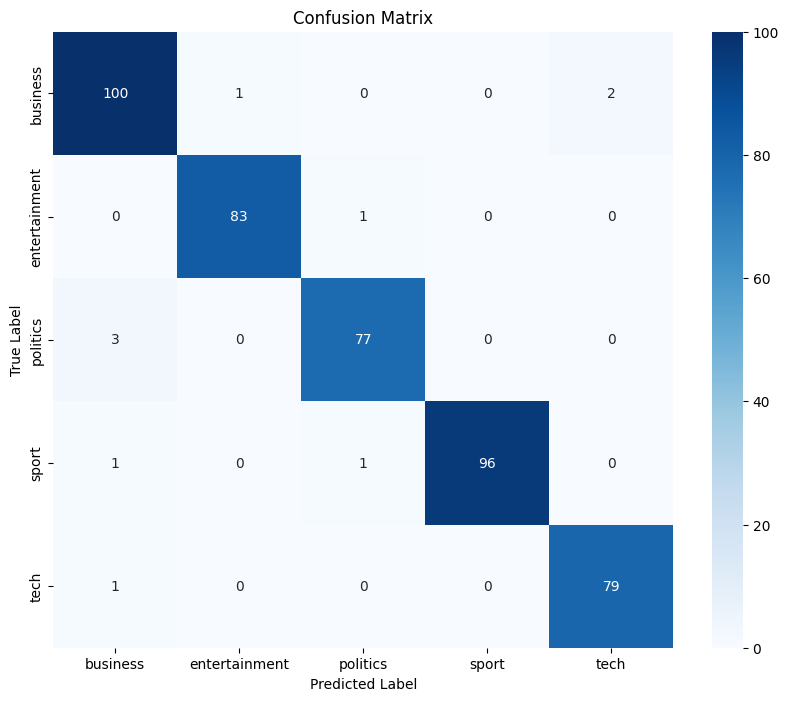


Testing the classify_text function:
Text: 'Shares in London fell today amid concerns about th...'
Predicted Category: business

Text: 'The government announced new measures to tackle cl...'
Predicted Category: business

Text: 'Liverpool won the match by two goals to nil....'
Predicted Category: sport

Text: 'Scientists have discovered a new species of bird....'
Predicted Category: sport

Text: 'A new art exhibition opened in the city....'
Predicted Category: entertainment



In [72]:
# prompt: test the model

# Evaluate the model on the validation dataset
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Get predictions on the validation dataset
val_preds_raw = trainer.predict(val_dataset)
val_preds = val_preds_raw.predictions.argmax(-1)
val_labels_true = val_preds_raw.label_ids

# Print classification report
print("\nClassification Report:")
print(classification_report(val_labels_true, val_preds, target_names=le.classes_))

# Plot confusion matrix
cm = confusion_matrix(val_labels_true, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Test the classify_text function with a few examples
sample_texts = [
    "Shares in London fell today amid concerns about the economy.", # Likely business
    "The government announced new measures to tackle climate change.", # Likely politics
    "Liverpool won the match by two goals to nil.", # Likely sport
    "Scientists have discovered a new species of bird.", # Likely science/tech
    "A new art exhibition opened in the city.", # Likely entertainment
]

print("\nTesting the classify_text function:")
for text in sample_texts:
    predicted_label_index = classify_text(text)
    predicted_label = le.inverse_transform([predicted_label_index])[0]
    print(f"Text: '{text[:50]}...'")
    print(f"Predicted Category: {predicted_label}\n")



In [73]:
  text = [
    "Shares in London fell today amid concerns about the economy.", # Likely business
    "The government announced new measures to tackle climate change.", # Likely politics
    "Liverpool won the match by two goals to nil.", # Likely sport
    "Scientists have discovered a new species of bird.", # Likely science/tech
    "A new art exhibition opened in the city.", # Likely entertainment
]

In [74]:
def predict_user_input(text):
    # Preprocess the input text using the same steps as the training data
    cleaned_text = preprocess_text(text)
    if not cleaned_text:
        return "Could not process input text."

    inputs = tokenizer(cleaned_text, return_tensors="pt", truncation=True, padding=True).to(model.device) # Ensure tensor is on the same device as model

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    pred = torch.argmax(outputs.logits).item()

    # Map predicted label index back to original class name
    predicted_label = le.inverse_transform([pred])[0]
    return predicted_label

# Get user input
user_text = input("Enter the news text you want to classify: ")

# Predict the category
predicted_category = predict_user_input(user_text)

print(f"\nThe entered text is likely from the '{predicted_category}' category.")

Enter the news text you want to classify: Honor X100 is Awesome 

The entered text is likely from the 'entertainment' category.
